In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as cl
from typing import Tuple
import seaborn as sns
import bioframe as bf
import cooler
import cooltools
import bbi

In [2]:
# ignore log10(0) warnings
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
def slidingDiamond(array: np.ndarray, sideLen: int = 6, centerX: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """Will slide a dimaond of side length 'sideLen'
    down the diagonal of the passed array and return
    the average values for each position and
    the relative position of each value with respect
    to the center of the array (in Bin units)"""
    # initialize accumulators for diamond value and x-position
    diamondAccumulator = list()
    binAccumulator = list()
    if sideLen % 2 == 0:
        halfWindow = sideLen
        for i in range(0, (array.shape[0] - halfWindow + 1)):
            # extract diamond
            diamondArray = array[i: (i+halfWindow), i:(i+halfWindow)]
            # set inf to nan for calculation of mean
            diamondArray[np.isinf(diamondArray)] = np.nan
            diamondAccumulator.append(np.nanmean(diamondArray))
            # append x-value for this particular bin
            binAccumulator.append(np.median(range(i, (i+halfWindow),)))
    else:
        halfWindow = sideLen//2
        for i in range(halfWindow, (array.shape[0] - halfWindow)):
            # extract diamond
            diamondArray = array[i-halfWindow: (i+halfWindow) + 1, i-halfWindow:(i+halfWindow) + 1]
            # set inf to nan for calculation of mean
            diamondArray[np.isinf(diamondArray)] = np.nan
            diamondAccumulator.append(np.nanmean(diamondArray))
            # append x-value for this particular bin
            binAccumulator.append(np.median(range(i - halfWindow, (i+halfWindow) + 1,)))
    if centerX:
        xOut = (np.array(binAccumulator - np.median(binAccumulator)))
    else:
        xOut = np.array(binAccumulator)
    return (xOut, np.array(diamondAccumulator))

## Set plotting parameters

In [4]:
mpl.rcParams.update({'pdf.fonttype': 42,
                     'ps.fonttype': 42,
                     'xtick.labelsize': 22,
                     'ytick.labelsize': 22,
                     'axes.labelsize':22,
                     'font.size': 22})

## Get chromosome arms

In [5]:
hg19_chromsizes = bf.fetch_chromsizes('hg19')
hg19_cens = bf.fetch_centromeres('hg19')
hg19_arms = bf.make_chromarms(hg19_chromsizes, hg19_cens)

## Upload cis and trans scsHi-C cooler files

In [6]:
# Define the window of interest (one-sided)
flank = 500000

# Define the resolution of the Hi-C data 
resolution = 10000

In [7]:
perturbation = 'WT'

# Load scsHi-C data based on the variable specified above (flank and resolution)
clrs = {rType:
        cooler.Cooler(
            f'/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler/G2.fc_1_2_3_4.wOldG2.{rType}.1000.mcool::/resolutions/{resolution}')
        for rType in ["cis", "trans"]
        }

## Fix the sorting of the hg_19 arms to match coolers 

In [8]:
hg19_arms.chrom = hg19_arms.chrom.astype("category")
hg19_arms.chrom = hg19_arms.chrom.cat.set_categories(clrs["trans"].chromnames)
hg19_arms = hg19_arms.sort_values(["chrom","start"])
hg19_arms.reset_index(inplace = True, drop = True)

## Calculate expected Hi-C values

In [9]:
# Calculate expected values 
expClrs = {interType:
       cooltools.expected_cis (clrs[interType], view_df=hg19_arms, smooth = True, aggregate_smoothed=True, nproc=2, chunksize=1_000_000)
       for interType in ["cis", "trans"]
      }

## Upload SMC3 without Sororin peaks

In [10]:
center = 'SMC3_wo_Sororin'
smc3_wo_sororin = pd.read_csv("/groups/gerlich/experiments/Experiments_005700/005784/data/signal_peak_classification/smc3_wo_sororin.bed", 
                                sep = "\t")

smc3_wo_sororin

,chrom,start,end,length,mid,SMC3,Sororin
0,chr1,793102,793758,656,793430,0.166118,0.090913
1,chr1,805255,805437,182,805346,0.165794,0.064613
2,chr1,824997,825153,156,825075,0.001243,0.032140
3,chr1,873361,874093,732,873727,0.213029,0.020669
4,chr1,950664,951140,476,950902,0.272368,0.076408
...,...,...,...,...,...,...,...
13843,chrX,154215355,154216046,691,154215700,0.124045,-0.000317
13844,chrX,154277189,154277846,657,154277517,0.230675,0.042113
13845,chrX,154285222,154286364,1142,154285793,0.470423,0.079979
13846,chrX,154314458,154315341,883,154314899,0.332665,-0.029144


In [11]:
# generate observed over expected Hi-C pile-ups
matricesObsExp = {}
for rType in ["cis", "trans"]:
    snippets = cooltools.pileup(clrs[rType], smc3_wo_sororin, view_df=hg19_arms, expected_df=expClrs[rType], flank=flank)
    matricesObsExp [rType] = snippets

In [12]:
obsExp1dWT = {}
for rType in ["cis", "trans"]:
    tempPile = matricesObsExp[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[0]):
        if boundaryIndex % 5000 == 0:
            print(boundaryIndex)
        indPile = tempPile[boundaryIndex]
        xVals, yVals = slidingDiamond(indPile, sideLen=10)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    obsExp1dWT[rType] = pd.concat(tempList)

0
5000
10000
0
5000
10000


## Order the stacks according to the value in the center of the stack

In [20]:
wtPrepared = {}
for rType in ["trans", "cis"]:
    temp = obsExp1dWT[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=True)
    if rType == "trans":
        # midPoint definitio
        midPoint = int(np.median(range(len(tempExp.columns))))
        # find center enrichment
        tempExp.loc[:, "CenterVal"] = tempExp.apply(lambda x: np.nanmean(x.iloc[midPoint-5:midPoint+5]), axis=1)
        tempExp = tempExp.sort_values(by="CenterVal", ascending=False).drop("CenterVal", axis="columns")
        transOrder = tempExp.index
    else:
        tempExp = tempExp.loc[transOrder, :]
    tempExp = tempExp.dropna()
    wtPrepared[rType] = tempExp

In [21]:
wtPrepared["trans"] = np.log2(wtPrepared["trans"] + 0.01)
wtPrepared["cis"] = np.log2(wtPrepared["cis"] + 0.01)

In [22]:
idx = np.random.permutation(wtPrepared["trans"].index)
wtPrepared["trans"] = wtPrepared["trans"].reindex(idx)
wtPrepared["cis"] = wtPrepared["cis"].reindex(idx)

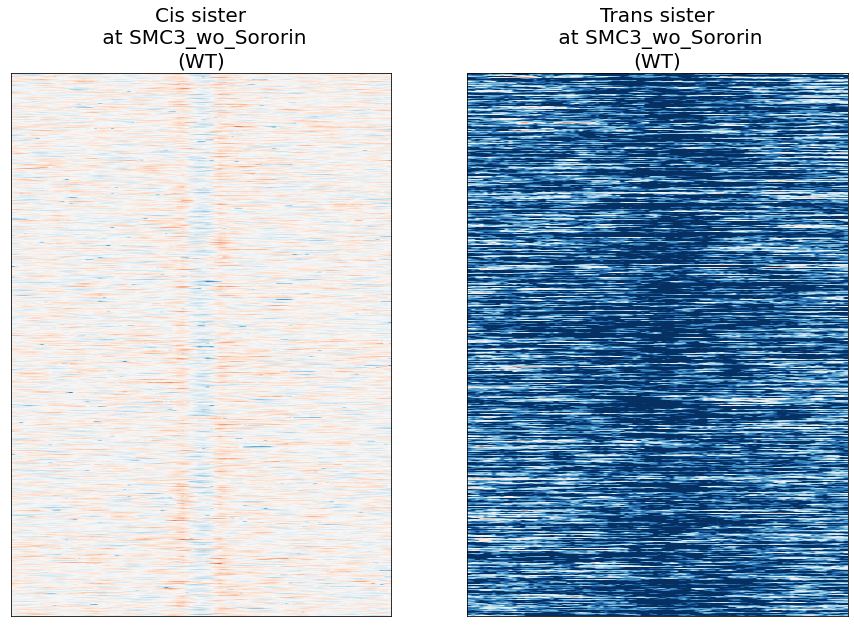

In [23]:
fig, ax = plt.subplots(1, 2)
im = ax[0].imshow(wtPrepared["cis"], vmin=-.8, vmax=.8, aspect='auto', cmap = mpl.cm.get_cmap('RdBu_r'), rasterized=True)
ax[1].imshow(wtPrepared["trans"], vmin=-.8, vmax=.8, aspect='auto', cmap = mpl.cm.get_cmap('RdBu_r'), rasterized=True)


ax[0].set_title(f"Cis sister\n at {center}\n(WT)", fontsize = 20)
#fig.colorbar(im, ax=ax[0], label="log2 (obs/exp)", location = 'bottom', shrink = 0.5)
ax[1].set_title(f"Trans sister\n at {center}\n(WT)", fontsize = 20)
#fig.colorbar(im, ax=ax[1], label="log2 (obs/exp)", location = 'bottom', shrink = 0.5)
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
fig.set_size_inches(15, 10)
plt.show()

In [24]:
resDir = "/groups/gerlich/experiments/Experiments_005700/005784/results/signal_peak_classification/lineprofiles/"
#fig.savefig (os.path.join(resDir, f"hic_line_profiles_wt_ObsExp_at_{center}_{resolution/1000}_window_{flank/1000}_res.png"), bbox_inches="tight", transparent = True)
#fig.savefig (os.path.join(resDir, f"hic_line_profiles_wt_ObsExp_at_{center}_{resolution/1000}_window_{flank/1000}_res.pdf"), bbox_inches="tight", transparent = True)